# Preliminary Results: Automated Glioma Segmentation using mixed-precision 3D UNet 
Diedre Santos do Carmo

## Abstract
Segmentation of Glioma from three dimensional magnetic resonance imaging (MRI) is necessary for diagnosis and surgical treatment of patients with brain tumor. Manual segmentation is expensive, requiring medical specialists. In the recent years, the Brain Tumor Segmentation Challenge (BraTS) has been calling researchers to submit automated glioma segmentation methods for evaluation and discussion over their public, multimodality MRI dataset, with manual annotations. This paper presents a variation of the famous encoder-decoder architecture, UNet, employing modern deep learning techniques in its architecture and optimization, including the use of mixed-precision. Preliminary results are reported, with best validation Dice for each BraTs target of WT: (TODO), TC: (TODO), EC: (TODO). 

## Executable Paper
This is an executable paper. The code cells can be run to reproduce important steps of this research.

Details from each run can be visualized by runnning "mlflow ui" on the directory of this notebook and accessing http://localhost:5000 on your browser. 

In [2]:
import os
from IPython.display import Image

# Some logs will be saved in "logs".
os.makedirs("logs", exist_ok=True)

## Introduction
Assessment of brain tumors is important in the diagnostic of Cancer <cite data-cite="7898824/32A6LUAJ"></cite>. Automatic segmentation can aid in this assessment, allowing for description of relevant tumor features such as its volume. However, tumors are very heterogeneous in shape, having different associated grades and classifications. Due to this variance, automatic segmentation of brain tumors is still a challenge <cite data-cite="7898824/B7ZKPB79"></cite>.

A source of public glioma type brain tumors is the BraTS challenge <cite data-cite="7898824/YLKCBVFB"></cite>. This challenge expects high quality automatic segmentations of glioma regions, annotated over the provided four modalities of MRI, T1, contrast enhanced T1, T2 and FLAIR. Submitted methods have to provide three segmentation maps: Whole Tumor (WT), Tumor Core (TC) and Enhancing Tumor (EC) (see Figure 1). The conception of the challenge came from the high inter-rater disagreement between expert raters in 2012 of up to 0.74 DICE <cite data-cite="7898824/93RWH6ZN"></cite>. Currently, most top-ranking methods in the challenge use Deep Learning <cite data-cite="7898824/T6JZA6G5"></cite> based methods. 

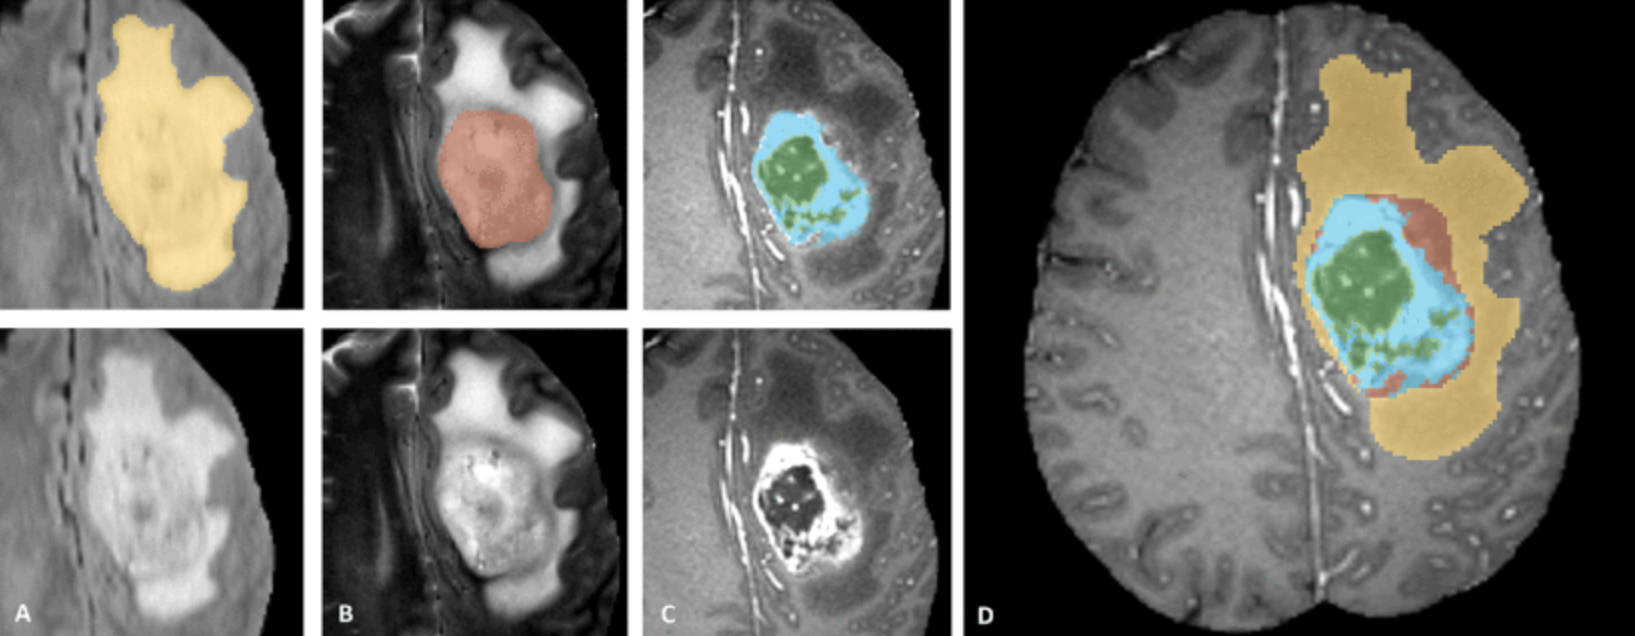

In [3]:
Image("figures/tumor_brats.png")

Figure 1: A sample manual annotation of a glioma. (a) edema (yellow), (b) non-enhancing solid core (red), (c) necrotic/cystic core (green), enhancing core(blue). (d) Combined segmentations. Reproduced from <cite data-cite="7898824/YLKCBVFB"></cite>.

Adaptation of the famous UNet <cite data-cite="7898824/WEA99PRW"></cite> architecture is a common approach in recent years, with many succesful methods, e. g.: <cite data-cite="7898824/552HYZPE"></cite>, <cite data-cite="7898824/N2ISPHA8"></cite>, <cite data-cite="7898824/97EEBQDV"></cite>, <cite data-cite="7898824/NDZEHRVN"></cite>, <cite data-cite="7898824/TJ8EPCJ6"></cite> and <cite data-cite="7898824/8WQUNYUI"></cite>. 

<cite data-cite="7898824/552HYZPE"></cite> achieved top perfomance using an ensemble of four medical image segmentation CNN architectures, including 2 U-Net based ones, winning BRATS in 2017. The author proposes that its ensemble strategy aims to reduce the impact of different hyperparameters and bias employed to each architecture, by averaging their results.

Isensee Et al. adapted the UNet for 3D convolutions, with more skip connections, less channels, intensive augmentation, and a multi-class adaptation of DICE Loss. Interestingly, this is one of the leading methods from the 2017 <cite data-cite="7898824/N2ISPHA8"></cite> and the 2018 <cite data-cite="7898824/97EEBQDV"></cite> challenge using mostly a single U-Net architecture, showing that a well trained U-Net can be superior to complex ensemble approaches. This work seems to have inspired a lot of the 2019 submissions, which used similar hyperparameters and attempt to use a modified 3D UNet.

The winner of the 2018 challenge also used an U-Net like architecture <cite data-cite="7898824/NDZEHRVN"></cite>. The main novelty of this work consisted of using a second branch in the decoder part of the architecture, reconstructing the original image as a means of regularization of the encoder. Another difference to basic U-Net is the use of a larger encoder, while most works keep the symmetry between encoder and decoder. 

Myronenko in 2019 <cite data-cite="7898824/TJ8EPCJ6"></cite> explored variations in the traditional 3D encoder-decoder architecture, repeatedly used in BraTS. This work uses group normalization instead of batch normalization. A custom loss of 3 terms is used, optimized with Adam and progressive learning rate reduction over 300 epochs. Hyperparameters are in general similar to Isensee's work.  The outputs consists of sigmoid nested tumor subregions. The main novelty is the exploration of the custom loss with dice, focal and Acl loss, which resulted in good relative performance to other submitted methods. 

The winner of the 2019 challenge <cite data-cite="7898824/8WQUNYUI"></cite> used two UNets, one producing a coarse segmentation and other refining that segmentation, using multi stage loss applications. Labels learned are directly the overlapping regions, with a modified Dice Loss where DICE per region is simply added, using similar parameters in optimization to Isensee's work. 

3D UNet like architectures have been achieving top performance in BraTS year after year. This paper proposes to further explore the potential of the UNet encoder-decoder architecture, in a mixed-precision ambient.

## Data
The BraTS 2020 dataset contains 369 MRI scans of various modalities: T1, post-contrast T1, T2, and FLAIR volumes. All scans are of Low or High grade gliomas (LGG/HGG), acquired with different clinical protocols and various scanners from multiple institutions.

All Subjects have manual segmentations, performed by one to four raters, following the same protocol, with the resulting segmentation being approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET), the peritumoral edema (ED), and the necrotic and non-enhancing tumor core (NET), as described in the latest BraTS summarizing paper <cite data-cite="7898824/B7ZKPB79"></cite>. Note that the challenge's evaluation is performed over three targets: the ET, the tumor core (TC) composed of ET + NET, and the Whole Tumor (WT) composed of ET + NET + ED. The provided data are distributed after pre-processing: co-registration to the same anatomical template, interpolation to the same resolution and skull-stripping.

Additional pre-processing applied in this methodology follows <cite data-cite="7898824/N2ISPHA8"></cite>. The images are subtracted by the mean and divided by the standard deviation of the brain region, and clipped inside the interval -5 to 5. Finally, they are min-max normalized to the interval 0 to 1. The targets are organized in a softmax manner, including background, resulting in four channels (background, ED, NET and ET). Experiments were also made with using sigmoid activations and optimizing directly over the three evaluation targets (WT, TC and ET).

This paper will split the challenge's (shuffled) training data in a hold-out approach of 70% training, 10% validation and 20% for the final test set, since the challenge validation and test sets are not available yet for 2020.  

The training data for 2020's challenge will be downloaded, pre processed and visualized by the following three code cells.

### Code Cell: Download the original BraTS 2020 data from figshare and unpack

In [ ]:
!python3 src/download_unpack.py

### Code Cell: Preprocess the data

In [ ]:
# "--nworkers" controls the number of processes used for pre-processing. Higher is faster but 
# uses more memory. "--nworkers auto" will use the higher between 2 or half the number of threads 
# in your CPU.
!python3 src/brats_preprocess.py --data_path data/MICCAI_BraTS2020_TrainingData --nworkers auto

### Code Cell: Generates and visualizes a display of the pre-processed data

In [ ]:
# Change --input to generate and visualize for another .npz file.
!python3 src/visualize_npz.py --input data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_preprocessed.npz --no_display

# This image is generated by the run above. 
Image("figures/display.png")                           

Figure 2: The four modalities are showcased, in order: FLAIR, T1, T1 with Contrast and T2. Also displayed in the bottom row are, in order: background, edema (ED), non-enhancing tumor (NET) and enhancing tumor (ET).

## Methodology

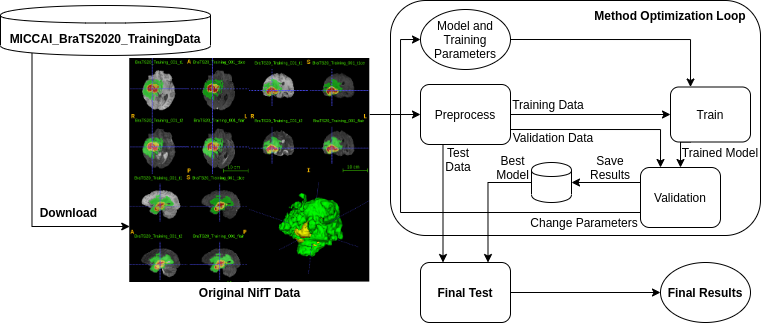

In [4]:
Image("figures/btrseg_workflow.png")

Figure 3: Workflow illustration of this research. The core machine learning loop is illustrated by the repeated training and validation with different parameters over the training and validaiton sets. The best validation results are used in the final test over the test set.

This method, named BTRSeg, leverages modified, fully 3D, UNet like encoder-decoder CNNs. This architecture is based on previous experiments with hippocampus segmentation and 2D UNets <cite data-cite="7898824/WJCC5N4Z"></cite>. We basically extended the E2DHipseg architecture to 3D convolutions, compensating the increased memory overhead with less channels. Instead of using the consensus of three networks, in this paper we purely explore the performance of one 3D architecture. The architecture still has residual connections <cite data-cite="7898824/QNWWLW55"></cite> in the convolution blocks, however the input is a 4-channel volume containing the FLAIR, T1, T1ce and T2 volumes. In theory, batch normalization <cite data-cite="7898824/Y6U2A4AN"></cite> may degrade training when using a small batch size. Therefore, experiments were performed in replacing batch normalization with group normalization <cite data-cite="7898824/HIMBM3ST"></cite>. 

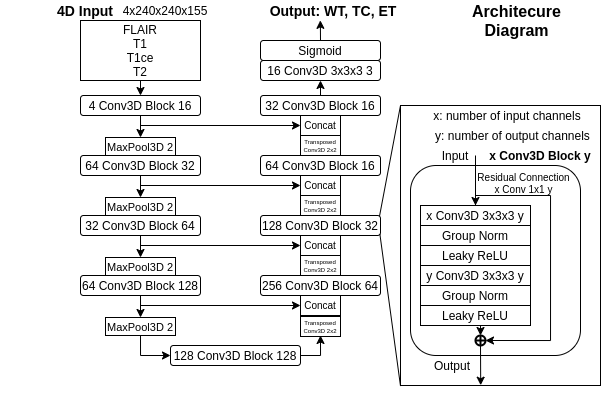

In [5]:
Image("figures/architecture_3dsmaller_updated.png")


Figure 4: A diagram of the architecture used in this work.

In regards to training methodology, we employ similar hyperparameters to <cite data-cite="7898824/N2ISPHA8"></cite>. A learning rate of 0.0005, weight decay of 1e-5, max epochs of 300, exponential LR decay by 0.985. Adam <cite data-cite="7898824/TCH4U8MR"></cite> and RAdam <cite data-cite="7898824/GQZ8MS8R"></cite> are experimented with for optimizers. The inputs are random patches of 128x128x128 for training, and center crops of 128x128x128 for validation. Group Normalization is also tested, however, it seems like its implementation requires more memory than Batch Normalization, which limits the possibility of increasing batch size. The used loss function consists of 1 - (WT_Dice + TC_Dice + ET_Dice)/3, basically 1 minus the mean of Dices for each BraTS evaluation target. 

One constant problem in 3D CNNs is the high usage of memory, limiting the size of batch size. The main hypothesis we want to analyze in this work is that using mixed precision training might enable higher batch sizes and better performance. To enable this, we used the AMP library from NVidia, built-in the pytorch-lightning framework. More optimal use of memory is enabled by replacing some representations to 16 bit precision instead of 32 bit, in what is called mixed-precision. 

## Experiments and Results

The following table showcases our results on the validation set.

| Method         | Optimizer  |Batch Size  | Precision | Normalization | Val Loss  | 
| ---            |  ---       | ---        | ---       | ---           | ---       | 
|  Isensee (2018)|  Adam      |   2        | full      | Instance Norm |   0.19    | 
|    BTRSeg      |  Adam      |   2        | full      | Batch Norm    |   0.19    | 
|    BTRSeg      |  Adam      |   6        | mixed     | Batch Norm    |   0.18    | 
|    BTRSeg      |  Adam      |   3        | mixed     | Group Norm    |   0.16    | 
|    BTRSeg      |  RAdam     |   2        | mixed     | Group Norm    |   ?       | 
|    BTRSeg      |  RAdam     |   3        | mixed     | Group Norm    |   0.16    |

Table 1: Each row is one full training, with validation loss for each BraTS target. Lower is better.

Table 1 shows that improving batch size with mixed precision and using group norm improved results in relation to batch normalization and batch size 2. Using RAdam seemed not to improve results. Figure 5 shows the progression of validation loss per epoch of training. All experiments were run in a Xeon E3-1220 v2 CPU with 32 GB of RAM and a 12 GB Nvidia GTX Titan X.

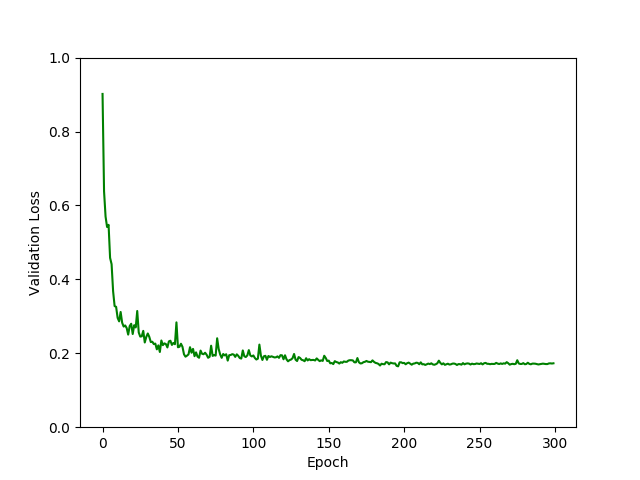

In [3]:
Image("figures/plot.png")

### Code Cell: Train Experiment

In [ ]:
# IMPORTANT: Results considered on the table are the ones on the model name in the ./models folder.
!python3 src/train.py

### Code Cell: Prediction on a Volume

In [ ]:
!python3 src/predict.py

## Discussion
Results show that it is possible to improve the performance of a 3D UNet performing segmentation of brain tumors simply by achieving larger batch sizes with mixed precision. Batch normalization, as shown by other works, does not deal well with low batch size. Group normalization improved results, however, the current official PyTorch implementation of group normalization uses more memory than batch norm, which limited our possibilities of increasing batch size even more. 

## Conclusion and Future Work
The improved performance coming from using increased batch size from mixed precision and group normalizaiton show that there is still room for improvement in this task. Future work intends to explore more variations on the architecture and hyperparameters, in an attempt to achieve similar or better performance than the top BraTS 2019 methods. 

## References
<div class="cite2c-biblio"></div>